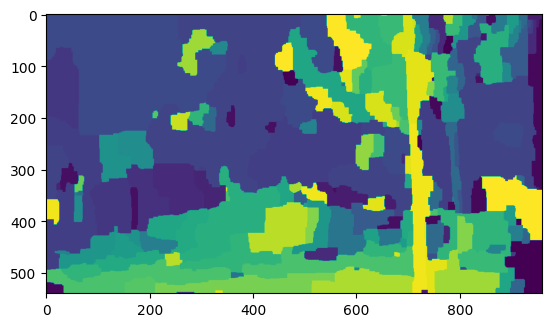

In [23]:
import gco
import cv2
import matplotlib.pyplot as plt
import numpy as np
import warnings

#read txt method one
Camera_prem = np.loadtxt("./cameras.txt")
camera_mat = Camera_prem.T
K1=camera_mat[:,0:3].T
R1=camera_mat[:,3:6].T
t1=camera_mat[:,6]
K2=camera_mat[:,7:10].T
R2=camera_mat[:,10:13].T
t2=camera_mat[:,13]

# load image
img1 = cv2.imread('test00.jpg')
img2 = cv2.imread('test09.jpg')

[H, W] = img1.shape[0:2]

# select image order
imgR = img1
imgL = img2
# imgR: in which objects are on the right in general.
# imgL: in which objects are on the left in general.

no_disparity = 50
# set disparity range: disparity = d_min:d_max
disparity = np.linspace(0, 0.0085, no_disparity)#list(range(0,no_disparity, 0.0085))

no_disparity = 50
# set disparity range: disparity = d_min:d_max
D = np.zeros([1, 50])
D[0,:] = np.linspace(0, 0.0085, no_disparity)  #list(range(0,no_disparity, 0.0085))

#N = size(img_seq1,1)
#D = linspace(0,0.0085,50); #good 0-0.085 50
C = no_disparity

unary = np.zeros([H, W, no_disparity])
#unary = ones(C,N)

[X, Y] = np.meshgrid(disparity,disparity)


for w in range(W):
    for h in range(H):

        n1 = (w-1)*H + h
        node1 = imgR[h,w,:].reshape([1,3])
        x1 = [w, h, 1]
        temp = np.zeros([3,1])
        temp[:,0] =  np.dot(np.dot(K2,R2.T)   ,  (t1-t2))
        temp2 = np.dot(temp, D)
        front_tmp = np.dot(K2, R2.T)
        front_tmp2 = np.dot(np.dot(front_tmp,  np.dot(np.linalg.inv(K1),R1)), x1)
        front_tmp3 = np.zeros([front_tmp2.shape[0],1])
        front_tmp3[:,0] = front_tmp2
        x2 = front_tmp3 + temp2

        x2_h = np.zeros([3, x2[2,:].shape[0]])
        x2_h[0,:] = x2[2,:].reshape(1, x2[2,:].shape[0])
        x2_h[1,:] = x2[2,:]
        x2_h[2,:] = x2[2,:]
        
        #x2_h = repmat(x2(3,:),3,1)
        x2 = np.round(np.divide(x2, x2_h))
        x2[0, x2[0,:]<0 ] = 0
        x2[0, x2[0,:]>W-1] = 0
        x2[1, x2[1,:]<0 ] = 0
        x2[1, x2[1,:]>H-1] = 0
        #n2 = (x2[0,:]-1)*H + x2[1,:]
        #n2_ls  = n2(n2<=518400 & n2>=1)
        for i in range(no_disparity):
            node2s = imgL[int(x2[1,i]), int(x2[0,i]),:]
            #node2s = img_seq2(n2_ls,:)
            match_cost = np.sqrt(sum((node1 - node2s)^2,2))
            unary[h,w,i] = sum(match_cost)
            #unary(n2<=518400 & n2>=1,n1) = match_cost

smooth = (1 - np.eye(no_disparity)) *0.2
labels = gco.cut_grid_graph_simple(unary/255, smooth, n_iter=-1)
new_image = np.reshape(labels, [H,W]).astype(int)


plt.figure(1)
plt.imshow(new_image.astype(int))


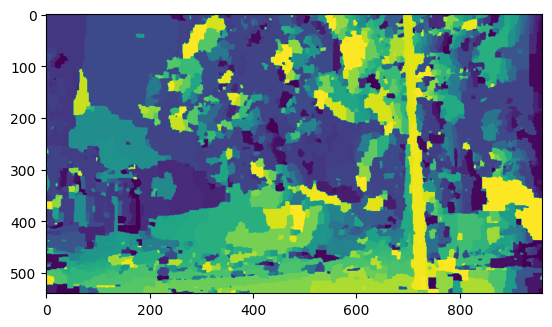

In [18]:
smooth = (1 - np.eye(no_disparity)) *0.1
labels = gco.cut_grid_graph_simple(unary/255, smooth, n_iter=-1)
new_image = np.reshape(labels, [H,W]).astype(int)


plt.figure(1)
plt.imshow(new_image.astype(int))

smooth = (1 - np.eye(no_disparity)) *0.08
labels = gco.cut_grid_graph_simple(unary/255, smooth, n_iter=-1)
new_image = np.reshape(labels, [H,W]).astype(int)


plt.figure(1)
plt.imshow(new_image.astype(int))

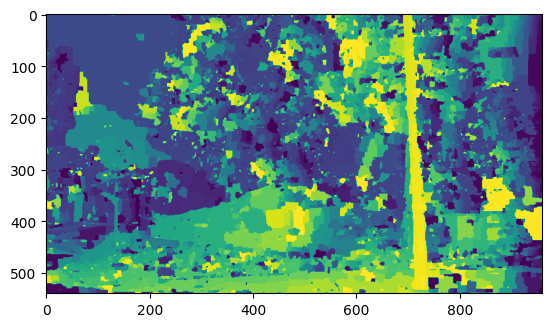

In [22]:
smooth = (1 - np.eye(no_disparity)) *0.07
labels = gco.cut_grid_graph_simple(unary/255, smooth, n_iter=-1)
new_image = np.reshape(labels, [H,W]).astype(int)


plt.figure(1)
plt.imshow(new_image.astype(int))

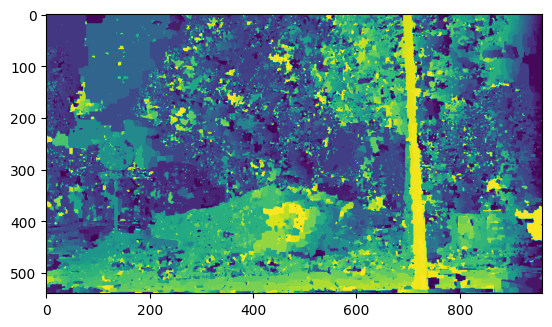

In [17]:
smooth = (1 - np.eye(no_disparity)) *0.04
new_image = np.reshape(labels, [H,W]).astype(int)
plt.figure(1)
plt.imshow(new_image.astype(int))

In [ ]:

for d in disparity:
    # fetch the left part of imgL
    imgL_left = imgL[:, 0:W-d]
    
    # fetch the right part of imgR
    imgR_right = imgR[:, d:W]
    
    # calculate the distance
    # dist = sum(abs(imgL_left - imgR_right), 3); % L1 distance
    dist = np.sqrt(((imgL_left - imgR_right)^2)) # L2 distance
    
    # padding with maximum depth when there is no value to compare
    # max_depth = 255 * 3; % L1 distance
    max_depth = np.sqrt(255)   #np.sqrt(255 ^ 2 * 3)  # L2 distance
    #if strcmp(direction, 'RIGHT-LEFT')
    dist_filled = np.zeros([H,W])
    dist_filled[0:H,0:d] = np.array([np.ones([H, d]) * max_depth])
    dist_filled[0:H,d:W] = dist
    #elseif strcmp(direction, 'LEFT-RIGHT')
    #    dist_filled = [dist, ones(H, d) * max_depth]';
    # vectorize
    unary[:,:, d] = dist_filled
